In [1]:
# ignore this
%load_ext music21.ipython21

# User's Guide, Chapter 20: Examples 2

Since the last set of example usages of `music21` in :ref:`Chapter 10 <usersGuide_10_examples1>`, we have covered the deeper features of the :class:`~music21.base.Music21Object`, looked at :class:`~music21.key.KeySignature` (and :class:`~music21.key.Key`) and :class:`~music21.meter.TimeSignature` objects, and understood how :class:`~music21.interval.Interval` objects are modeled.  This chapter gives us a chance to put some of our knowledge together by analyzing pieces and repertories of music using this information.

## Gap-Fill analysis

In a remarkable set of articles and other works from 1998-2000, Paul von Hippel explored the concept of "Gap-Fill," or the supposed idea that after a large leap in the melody, the listener expects that the following motion will be in the opposite direction, thereby filling the gap that was just created.  Hippel's work compared melodic motion to the average note height in a melody. When the melody leaps up it is often above the mean so there are more pitches available below the current note than above.  Similarly, when it leaps down, it is often below the mean, so there are more pitches above the current note than below.  Hippel's work showed that much or all of what we perceive to be gap-fill can be explained by "regression to the mean."  (The work is summarized beautifully in chapters 5 & 6 of David Huron's book _Sweet Anticipation_). But there are many repertories that have not yet been explored.  Let us see if there is a real Gap Fill or just regression to the mean in one piece of early fifteenth century music, using `Interval` objects as a guide.

First let's parse a piece that has been unedited except in the music21 corpus, a Gloria in the manuscript Bologna Q15 [(image available)](https://www.diamm.ac.uk/sources/117/#/images?p=45v) by a composer named "D. Luca".

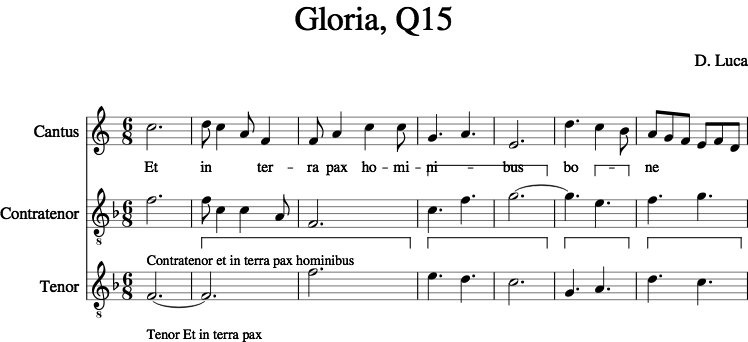

In [2]:
from music21 import *

luca = corpus.parse('luca/gloria')
luca.measures(1, 7).show()

For now, let's look at the top part alone:

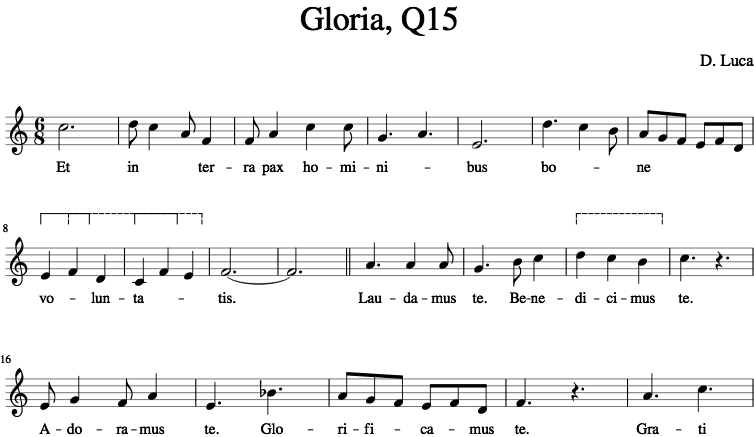

In [3]:
cantus = luca.parts['Cantus']
cantus.measures(1, 20).show()

Let us figure out the average pitch height in the excerpt by recursing through all the `Note` objects and finding getting the average of the `.ps` value, where Middle C = 60.  (Similar to the `.midi` value)

In [4]:
totalNotes = 0
totalHeight = 0
for n in cantus.recurse().getElementsByClass('Note'):
    totalNotes += 1
    totalHeight += n.pitch.ps
averageHeight = totalHeight/totalNotes
averageHeight

67.41100323624596

We can figure out what approximately what note that is by creating a new `Note` object:

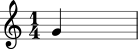

In [5]:
averageNote = note.Note()
averageNote.pitch.ps = round(averageHeight)
averageNote.show()

(It's possible to get a more exact average pitch, if we care about such things, when we get to microtones later...)

In [6]:
exactAveragePitch = pitch.Pitch(ps=averageHeight)
exactAveragePitch.step

'G'

In [7]:
exactAveragePitch.accidental

<accidental half-sharp>

In [8]:
exactAveragePitch.microtone

(-9c)

For users of Python 3, there are some even easier ways to get the average pitch, using the mean or the median:

In [9]:
import statistics
statistics.mean([p.ps for p in cantus.pitches])

67.41100323624596

In [10]:
statistics.median([p.ps for p in cantus.pitches])

67.0

Medians are usually more useful than means in doing statistical analysis, so we'll use medians for our remaining analyses:

In [11]:
medianHeight = statistics.median([p.ps for p in cantus.pitches])

Okay, now let us get all the intervals in a piece.  We'll do this in an inefficient but easy to follow manner first and then later we can talk about adding efficiencies.  We'll recurse through the `Part` object and get the `.next()` :class:`~music21.note.Note` object each time and create an interval for it.

In [12]:
allIntervals = []
for n in cantus.recurse().getElementsByClass('Note'):
    nextNote = n.next('Note')
    if nextNote is None: # last note of the piece
        continue
    thisInterval = interval.Interval(n, nextNote)
    allIntervals.append(thisInterval)

Let's look at some of the intervals and also make sure that the length of our list makes sense:

In [13]:
allIntervals[0:5]

[<music21.interval.Interval M2>,
 <music21.interval.Interval M-2>,
 <music21.interval.Interval m-3>,
 <music21.interval.Interval M-3>,
 <music21.interval.Interval P1>]

In [14]:
len(allIntervals)

308

In [15]:
len(cantus.recurse().getElementsByClass('Note'))

309

Let's look at that first Interval object in a bit more detail to see some of the things that might be useful:

In [16]:
firstInterval = allIntervals[0]
firstInterval.noteStart

<music21.note.Note C>

In [17]:
firstInterval.noteEnd

<music21.note.Note D>

In [18]:
firstInterval.direction

<Direction.ASCENDING: 1>

We are only going to be interested in intervals of a third or larger, so let's review how to find generic interval size:

In [19]:
firstInterval.generic

<music21.interval.GenericInterval 2>

In [20]:
firstInterval.generic.directed

2

In [21]:
secondInterval = allIntervals[1]
secondInterval.generic.directed

-2

In [22]:
secondInterval.generic.undirected

2

In order to see whether gap-fill or regression to the mean is happening at any given moment, we need to only look at leaps up that after the leap are still below the mean or leaps down that finish above the mean.  For instance, if a line leaps up and is above the mean then both the gap-fill and the regression to the mean hypothesis would predict a downward motion for the next interval, so no knowledge would be gained.  But if the line leaps up and is below the mean then the gap-fill hypothesis would predict downward motion, but the regression to the mean hypothesis would predict upward motion for the next interval.  So motion like this is what we want to see.

Let's define a function called `relevant()` that takes in an interval and says whether it is big enough to matter and whether the gap-fill and regression hypotheses predict different motions:

In [23]:
def relevant(thisInterval):
    if thisInterval.generic.undirected < 3:
        return False
    noteEndPs = thisInterval.noteEnd.pitch.ps
    if thisInterval.direction == interval.Direction.ASCENDING and noteEndPs < medianHeight:
        return True
    elif thisInterval.direction == interval.Direction.DESCENDING and noteEndPs > medianHeight:
        return True
    else:
        return False

There won't be too many relevant intervals in the piece:

In [24]:
[relevant(i) for i in allIntervals].count(True)

22

In [25]:
[relevant(i) for i in allIntervals[0:10]]

[False, False, True, False, False, False, False, False, False, False]

The third interval is relevant.  Let's review what that interval is.  It's the C5 descending to A4, still above the average note G4.  Gap-fill predicts that the next note should be higher, regression predicts that it should be lower.

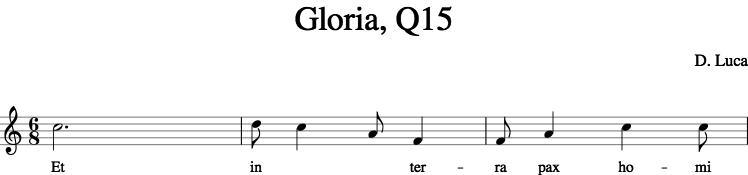

In [26]:
cantus.measures(1, 3).show()

In this case, the regression to the mean hypothesis is correct and the gap-fill hypothesis is wrong.  But that's just one case, and these sorts of tests need to take in many data points.  So let us write a function that takes in a relevant interval and the following interval and says whether gap-fill or regression is correct.  We will return 1 if gap-fill is correct, 2 if regression is correct, or 0 if the next interval is the same as the current.

In [27]:
def whichHypothesis(firstInterval, secondInterval):
    if secondInterval.direction == interval.Direction.OBLIQUE:
        return 0
    elif secondInterval.direction != firstInterval.direction:
        return 1
    else:
        return 2


In [28]:
whichHypothesis(allIntervals[2], allIntervals[3])

2

We can run this analysis on the small dataset of 32 relevant intervals in the cantus part.  We will store our results in a three-element list containing the number of oblique intervals, the number that fit the gap-fill hypothesis, and the number which fit the regression hypothesis:

In [29]:
obliqueGapRegression = [0, 0, 0]

for i in range(len(allIntervals) - 1):
    thisInterval = allIntervals[i]
    nextInterval = allIntervals[i + 1]
    if not relevant(thisInterval):
        continue
    hypothesis = whichHypothesis(thisInterval, nextInterval)
    obliqueGapRegression[hypothesis] += 1
    
obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

([6, 10, 6], 4)

So for this small set of data, gap-fill is more predictive than regression.  Let's run it on the whole piece.  First we will need to redefine `relevant` to take the average pitch height as a parameter.

In [30]:
def relevant2(thisInterval, medianHeight):
    if thisInterval.generic.undirected < 3:
        return False
    noteEndPs = thisInterval.noteEnd.pitch.ps
    if thisInterval.direction == interval.Direction.ASCENDING and noteEndPs < medianHeight:
        return True
    elif thisInterval.direction == interval.Direction.DESCENDING and noteEndPs > medianHeight:
        return True
    else:
        return False

And let's define a function that computes hypothesisTotal for a single part.

In [31]:
def onePartHypothesis(part):
    obliqueGapRegression = [0, 0, 0]

    medianHeight = statistics.median([p.ps for p in part.pitches])
    allIntervals = []
    for n in part.recurse().getElementsByClass('Note'):
        nextNote = n.next('Note')
        if nextNote is None: # last note of the piece
            continue
        thisInterval = interval.Interval(n, nextNote)
        allIntervals.append(thisInterval)
    
    for i in range(len(allIntervals) - 1):
        thisInterval = allIntervals[i]
        nextInterval = allIntervals[i + 1]
        if not relevant2(thisInterval, medianHeight):
            continue
        hypothesis = whichHypothesis(thisInterval, nextInterval)
        obliqueGapRegression[hypothesis] += 1

    return obliqueGapRegression

When I refactor, I always make sure that everything is still working as before:

In [32]:
onePartHypothesis(cantus)

[6, 10, 6]

Looks good! Now we're ready to go:

In [33]:
obliqueGapRegression = [0, 0, 0]

for p in luca.parts:
    onePartTotals = onePartHypothesis(p)
    obliqueGapRegression[0] += onePartTotals[0]
    obliqueGapRegression[1] += onePartTotals[1]
    obliqueGapRegression[2] += onePartTotals[2]
    
obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

([7, 20, 28], -8)

The lower two parts overwhelm the first part and it is looking like regression to the mean is ahead. But it's only one piece!  Let's see if there are other similar pieces in the corpus.  There's a collection of works from the 14th century, mostly Italian works: 

In [34]:
corpus.search('trecento')

<music21.metadata.bundles.MetadataBundle {103 entries}>

Let's run 20 of them through this search and see how they work!

In [36]:
obliqueGapRegression = [0, 0, 0]

for trecentoPieceEntry in corpus.search('trecento')[:20]:
    parsedPiece = trecentoPieceEntry.parse()
    for p in parsedPiece.parts:
        onePartTotals = onePartHypothesis(p)
        obliqueGapRegression[0] += onePartTotals[0]
        obliqueGapRegression[1] += onePartTotals[1]
        obliqueGapRegression[2] += onePartTotals[2]
    
obliqueGapRegression, obliqueGapRegression[1] - obliqueGapRegression[2]

([27, 86, 84], 2)

So it looks like neither the gap-fill hypothesis or the regression to the mean hypothesis are sufficient in themselves to explain melodic motion in this repertory.  In fact, a study of the complete encoded works of Palestrina (replace 'trecento' with 'palestrina' in the search and remove the limitation of only looking at the first 20, and wait half an hour) showed that there were 12,089 relevant instances, with 2334 followed by a unison, but 5130 exhibiting gap-fill behavior and only 4625 following regression to the mean, with a difference of 5.2%.  This shows that regression to the mean cannot explain all of the reversion after a leap behavior that is going on in this repertory.  I'm disappointed because I loved this article, but it'll come as a relief to most teachers of modal counterpoint.